In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

In [2]:
tra_dir = 'D:/MODELING ML/YoloDatasetV3_TampakAtas/train'
val_dir = 'D:/MODELING ML/YoloDatasetV3_TampakAtas/val'

In [3]:
# Definisikan parameter
IMAGE_SIZE = (416, 416)
BATCH_SIZE = 64
SEED = 999

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

In [5]:
train_data = datagen.flow_from_directory(
    tra_dir,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    val_dir,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3043 images belonging to 5 classes.
Found 1209 images belonging to 5 classes.


In [6]:
# Load EfficientNetV2S with pretrained weights, excluding the top layers
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(416, 416, 3)
)

In [7]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
output = Dense(5, activation='softmax')(x)

# Create the model
model_TL = Model(inputs=base_model.input, outputs=output)

In [8]:
# Compile the model
model_TL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 207, 207, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 207, 207, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 207, 207, 32)         0         ['batch_normalization[0][0

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

]

In [10]:
history_TL = model_TL.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=callbacks_list
)

Epoch 1/100


48/48 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.7256 
Epoch 1: val_accuracy improved from -inf to 0.51282, saving model to best_model.h5


d:\MODELING ML\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 716s 15s/step - loss: 0.6939 - accuracy: 0.7256 - val_loss: 1.7451 - val_accuracy: 0.5128 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8975 
Epoch 2: val_accuracy improved from 0.51282 to 0.86435, saving model to best_model.h5
48/48 [==============================] - 659s 14s/step - loss: 0.2730 - accuracy: 0.8975 - val_loss: 0.3868 - val_accuracy: 0.8644 - lr: 1.0000e-04
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9520 
Epoch 3: val_accuracy improved from 0.86435 to 0.91729, saving model to best_model.h5
48/48 [==============================] - 626s 13s/step - loss: 0.1472 - accuracy: 0.9520 - val_loss: 0.2372 - val_accuracy: 0.9173 - lr: 1.0000e-04
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9632 
Epoch 4: val_accuracy improved from 0.91729 to 0.94376, saving model to best_model.h5
48/48 [===

In [11]:
# Freezing layers in the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 249

In [13]:
for layer in base_model.layers[:fine_tune_at]:
   layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
   layer.trainable = True

In [14]:
# Compile the model
model_TL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Print model summary
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 207, 207, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 207, 207, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 207, 207, 32)         0         ['batch_normalization[0][0

In [15]:
# Fine-tuning training
history_TL_fine_tune = model_TL.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=callbacks_list
)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980
Epoch 1: val_accuracy did not improve from 0.98180
48/48 [==============================] - 250s 5s/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0892 - val_accuracy: 0.9744 - lr: 1.0000e-07
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9984
Epoch 2: val_accuracy did not improve from 0.98180
48/48 [==============================] - 241s 5s/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0779 - val_accuracy: 0.9793 - lr: 1.0000e-07
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9961
Epoch 3: val_accuracy did not improve from 0.98180
48/48 [==============================] - 240s 5s/step - loss: 0.0092 - accuracy: 0.9961 - val_loss: 0.0875 - val_accuracy: 0.9777 - lr: 1.0000e-07
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9970
Epoch 4: val_accuracy did 

In [ ]:
# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model("best_model.h5")

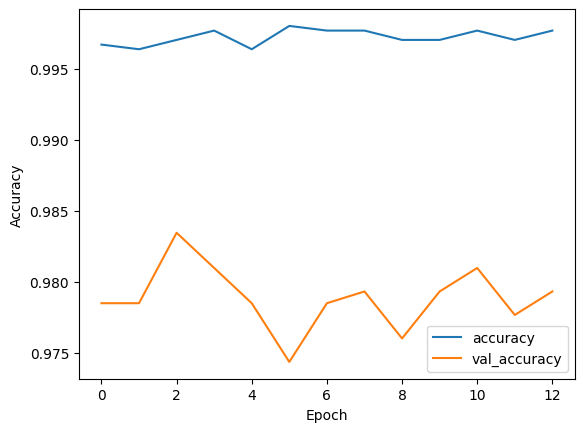

In [ ]:
plt.plot(history_TL_fine_tune.history['accuracy'], label='accuracy')
plt.plot(history_TL_fine_tune.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

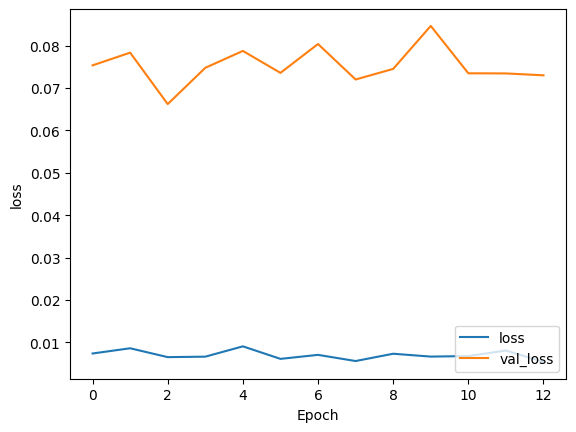

In [ ]:
plt.plot(history_TL_fine_tune.history['loss'], label='loss')
plt.plot(history_TL_fine_tune.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')


In [ ]:
history_TL_fine_tune.save('CNN_TL_INV3.h5')

AttributeError: 'History' object has no attribute 'save'

1/1 [==============================] - 0s 24ms/step


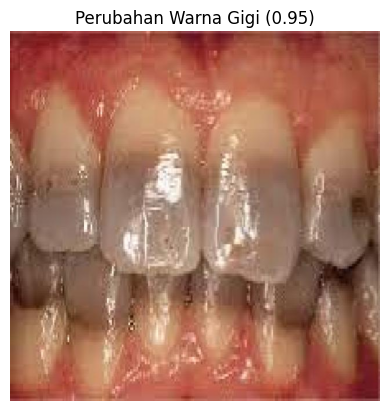

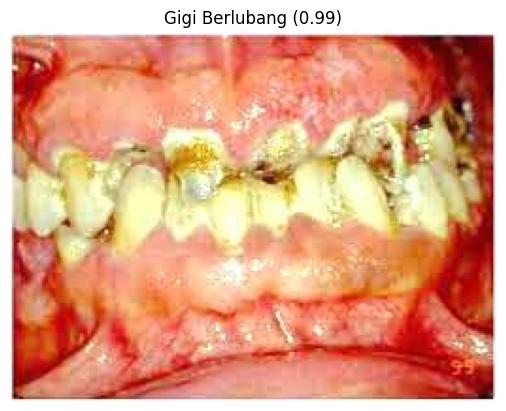

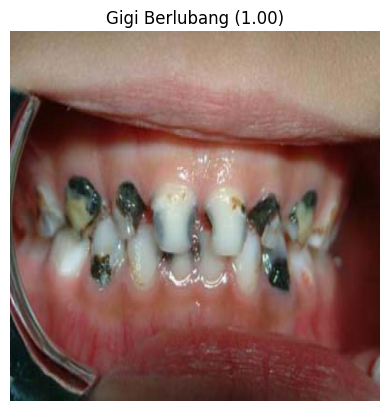

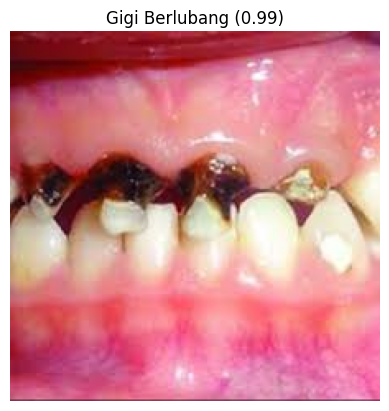

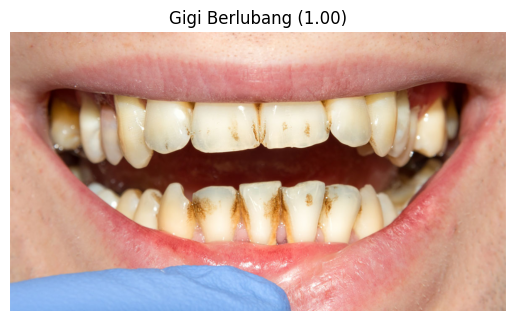

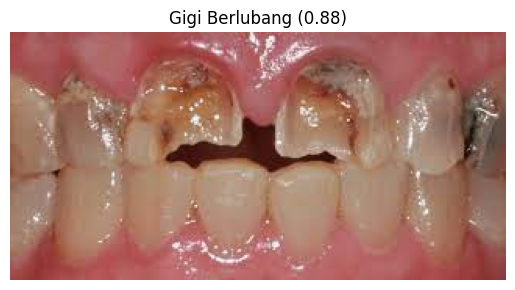

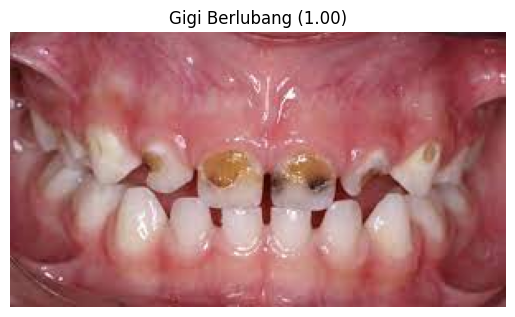

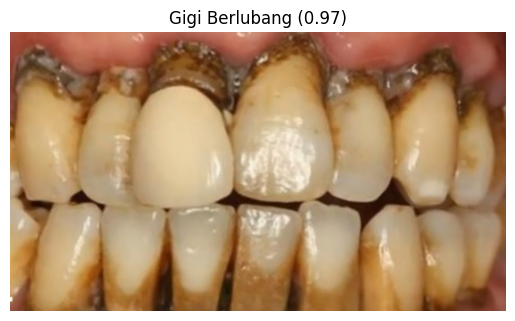

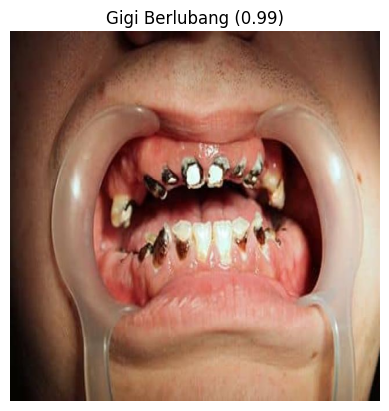

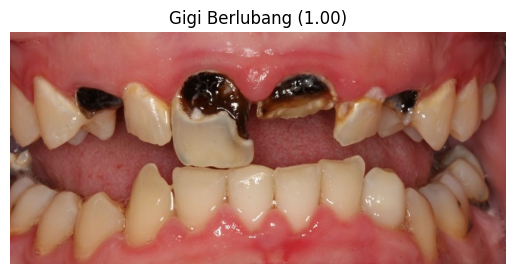

Accuracy for 'Gigi Berlubang': 0.89


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class labels
class_labels = ['Bukan Gigi', 'Gigi Berlubang', 'Gigi Sehat', 'Perubahan Warna Gigi', 'Radang Gusi']

# Path to the folder containing images
folder_path = 'D:/MODELING ML/YoloDatasetV3_TampakAtas/test/Gigi Berlubang'  # Update with the path to your folder

# Load the model
loaded_model = load_model('best_model.keras')

# Define image size (make sure this matches the size used in training)
IMAGE_SIZE = (224, 224)  # Update with the actual image size used in training

# Lists to store predicted labels and confidences
predicted_labels = []
confidences = []

# Iterate over all images in the folder
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)

    # Load and preprocess the image
    img = load_img(image_path, target_size=IMAGE_SIZE)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Ensure that the image is scaled the same way as during training

    # Predict the class
    classes = loaded_model.predict(x, batch_size=1)
    predicted_class_index = np.argmax(classes)

    # Get the predicted label and confidence
    if predicted_class_index < len(class_labels):
        predicted_label = class_labels[predicted_class_index]
        confidence = classes[0][predicted_class_index]
    else:
        predicted_label = 'Gigi Berlubang'
        confidence = 0.0

    # Store predicted label and confidence
    predicted_labels.append(predicted_label)
    confidences.append(confidence)

# Randomly select 10 images for display
random.seed(42)  # For reproducibility
display_indices = random.sample(range(len(predicted_labels)), min(10, len(predicted_labels)))

# Display the selected images
for index in display_indices:
    image_path = os.path.join(folder_path, os.listdir(folder_path)[index])

    # Display the image and prediction
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{predicted_labels[index]} ({confidences[index]:.2f})")
    plt.show()

# Calculate and print accuracy for '0 Perubahan Warna Gigi'
total_predictions = len(predicted_labels)
if total_predictions > 0:
    correct_predictions = predicted_labels.count('Gigi Berlubang')
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy for 'Gigi Berlubang': {accuracy:.2f}")
else:
    print("No images predicted as 'Gigi Berlubang' found.")
